# 08: Radial basis functions (RBF networks)

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import mylib as my

One way of implementing the idea of receptive fields is through the use of radial basis functions. Here we can let example $x_n$ or a group of examples represented by their center $\mu_n$ have a say in the outcome of an unseen example $x$ depending on how far these examples are from it. The farthest away they are from the unseen example, the least say they have in its outcome. A common way to implement this is using a Gaussian, which gives us bumps like this.

<img src="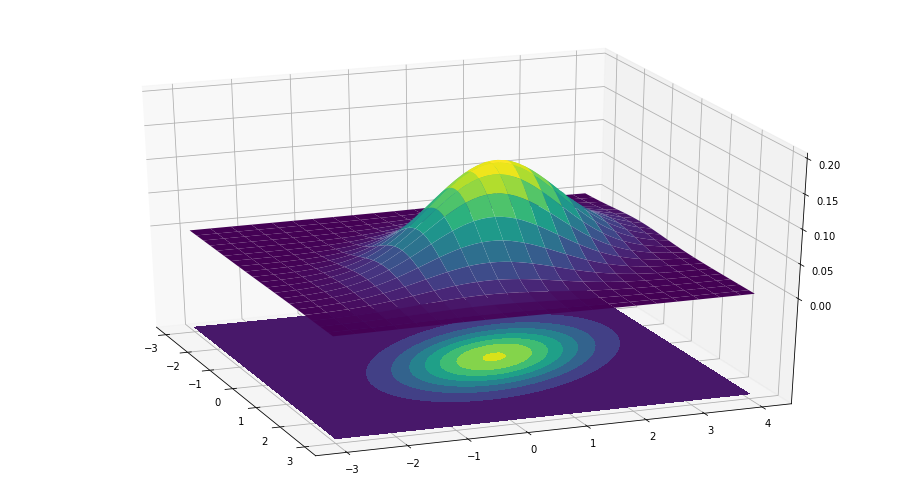
" class="unconfined">

The Gaussian represents a bump that decays as we move away from the center. The contours of this bump shows us points that have the same distance from the center. That is why we also call this function a radial basis function.

For a training example $n$, this Gaussian has the formula:
$$g_n(\mathbf{x}) = exp(\frac{-\|\mathbf{x} - \mathbf{x}_n\|}{r})$$ 
where $\mathbf{x}_n$ is a training example $n$, $\mathbf{x}$ is the unseen example, $\|\mathbf{x} - \mathbf{x_n}\|$ is the Euclidean distance, and $r$ is $2 \sigma^2$.

Accounting for the effect of all the training examples can lead to overfitting. So we use only a representatives of the training examples. In this case, the formula: 

$$g_n(\mathbf{x}) = exp(\frac{-\|\mathbf{x} - \mathbf{\mu}_n\|}{r})$$ 
where $\mathbf{\mu}_n$ is a center representing a group of training examples.

Using Gaussian radial basis functions we can have a hypothesis like this:

$$h(\mathbf{x}) = \sum_{n=1}^{N} w_n g_n(\mathbf{x})$$

or in matrix notation for an array of examples $X$:

$$h(\mathbf{X}) = \mathbf{G} \mathbf{w} $$

This hypothesis is for regression. For binary classification we can do something similar to the perceptron:

$$h(\mathbf{x}) = sign(\mathbf{G} \mathbf{w})$$

or the logistic regression:

$$h(\mathbf{x}) = \frac{1}{1 + e^{-\mathbf{G} \mathbf{w}}}$$

For multiclass classification, we can use the softmax activation function.

We can put all that together using a radial basis function (RBF) network that looks like this:

We can learn the weights in one of two ways:
* using the perceptron learning algorithm
* using the a normal equation just like linear regression

Here is an implementation using the normal equation:

$$ \mathbf{w} = (\mathbf{G}^T\mathbf{G})^{-1}\mathbf{G}^T y$$

where $(\mathbf{G}^T\mathbf{G})^{-1}\mathbf{G}^T$ is the pseudo-inverse. By default, this implementation supports linear regression. The `outType` argument should be `perceptron` for binary classification and `softmax` for multiclass classification.

In [3]:
class RBFNet:
    def __init__(self, dataset, sigma=0, mu=None, nOutput=1, outType='linear'):
        self.inputs = dataset.examples.values[:, :-nOutput]
        self.target = dataset.examples.values[:, -nOutput:]
        self.mu = self.inputs if mu is None else mu 
        self.nOutput = nOutput
        self.outType = outType
        max_range = (self.inputs.max(axis=0) - self.inputs.min(axis=0)).max()
        self.sigma =  max_range / np.sqrt(2 * len(self.mu)) if sigma == 0 else sigma
        self.r = 2 * self.sigma**2
        self.bias = len(self.mu) == len(self.inputs)
        
    def rbf(self, xn, sigma):
        d = self.inputs - np.ones([1, len(xn)]) * xn
        return nb.exp(np.sum(d**2,axis=1)/(self.r))
    
    def fit(self):
        G = np.array([np.exp(-np.linalg.norm(self.inputs - i,axis=1) / self.r) for i in self.mu]).T
        if self.bias:
            G = np.concatenate([np.ones([len(self.inputs), 1]), G], axis=1)
            
        y = self.target
        self.w = np.dot(np.linalg.pinv(G), y)

    def predict(self, unseen):
        if unseen.ndim == 1:
            x = np.exp(-np.linalg.norm(self.mu - unseen,axis=1) / self.r)
            if self.bias:
                x = np.insert(x, 0, 1)
                
            y = np.dot(x, self.w)
            if self.outType == 'softmax':
                return np.argmax(np.exp(y) / np.sum(np.exp(y)))
            elif self.outType == 'perceptron':
                return np.sign(y)
            else:
                return y
        else:
            return np.array([self.predict(ex) for ex in unseen])

## Using RBF networks for regression

Let's test this network. First we create a dataset:

In [4]:
x = np.arange(0, 15, .1)
y = 2 * x + 2 + np.random.normal(loc=2, scale=5, size=len(x))

df = pd.DataFrame({'x': x, 'y': y})
data = my.DataSet(df, y=True)

and plot it:

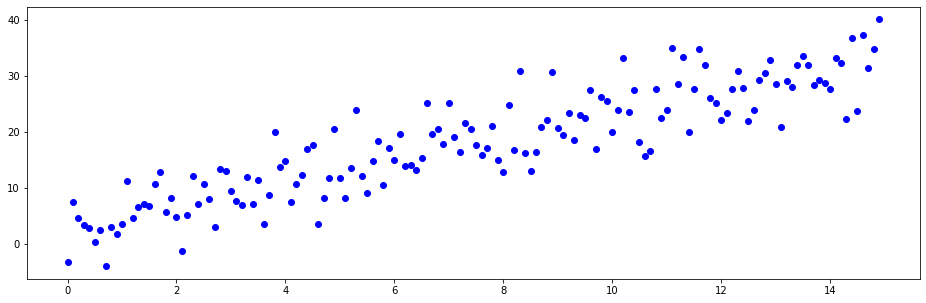

In [5]:
fig = plt.figure(figsize=(16,5))
plt.scatter(x, y, color='b', marker='o')

Now we fit an RBF network to this data:

In [7]:
rbf = RBFNet(data, mu=data.inputs[0::10,:])
rbf.fit()

Here we picking every 10th training example. Play with that number to see the difference. Let's plot the outcome:

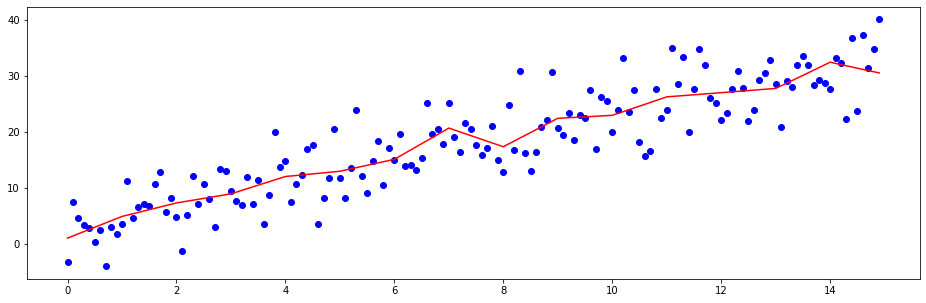

In [8]:
fig = plt.figure(figsize=(16,5))
plt.scatter(x, y, color='b', marker='o')

plt.plot(x, rbf.predict(data.inputs), color='r')

## Using RBF networks for binary classification
Here we have a dataset with two classes. We'll use the perceptron activation function at the output layer. Here is a sample dataset.

In [61]:
n = 150
data = np.array([[3, 14],[10, 9]])
d0 = np.concatenate((data[0,0] + np.random.normal(loc=1, scale=2.8, size=(n, 1)), 
                data[0, 1] + np.random.normal(loc=1, scale=1.2, size=(n, 1)), np.full(n, -1).reshape(n, 1)), axis= 1)

d1 = np.concatenate((data[1,0] + np.random.normal(loc=.5, scale=2.5, size=(n, 1)), 
                data[1, 1] + np.random.normal(loc=.5, scale=1, size=(n, 1)), np.ones(n).reshape(n, 1)), axis= 1)


d = np.concatenate((d0, d1), axis=0)
data = my.DataSet(pd.DataFrame(d, columns=['x1', 'x2', 'y']), y=True)

train, test = data.train_test_split(test_portion=0.33, shuffle=True)


Let's fit an RBF network to this dataset using all training examples

In [82]:
rbf = RBFNet(train, mu=train.inputs[::1,:], outType='perceptron')
rbf.fit()

cm = my.confusion_matrix(train.target, rbf.predict(train.inputs))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Training accuracy: ', accuracy)

cm = my.confusion_matrix(test.target, rbf.predict(test.inputs))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Testing accuracy: ', accuracy)

[[  0   0   0]
 [ 39   3  58]
 [  0   0 101]]
Training accuracy:  0.5174129353233831
[[ 0 50]
 [ 0 49]]
Testing accuracy:  0.494949494949495


Here are the decision regions' plots for both the training and testing datasets.

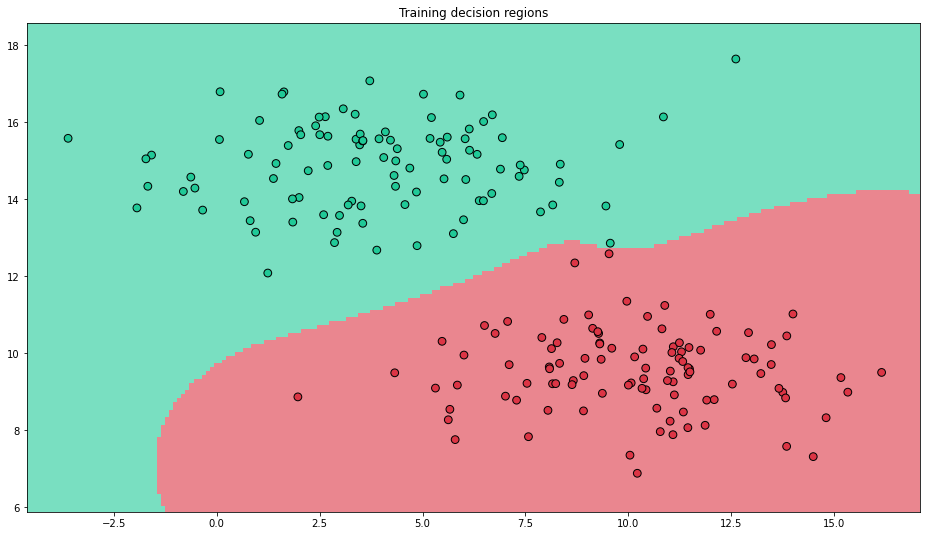

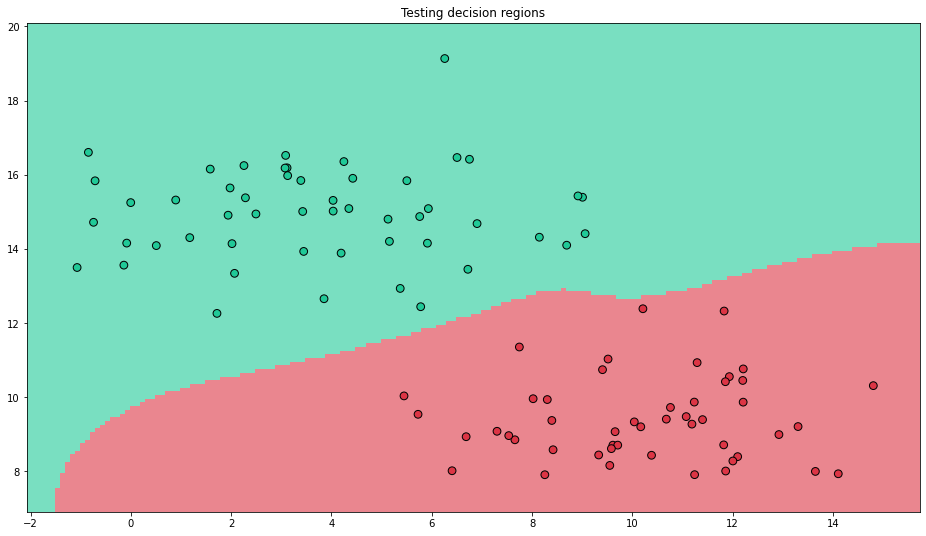

In [11]:
my.plot_decision_regions(train.inputs, train.target, rbf, resolution=0.1, title="Training decision regions")
my.plot_decision_regions(test.inputs, test.target, rbf, resolution=0.1, title="Testing decision regions")

Let's try this with only two centers.

In [12]:
mu0 = d0.mean(axis=0).reshape(1, 3)
mu1 = d1.mean(axis=0).reshape(1, 3)
mu = np.concatenate([mu0, mu1], axis=0)

rbf = RBFNet(train, mu=mu[:,:-1], outType='perceptron')
rbf.fit()

cm = my.confusion_matrix(train.target, rbf.predict(train.inputs))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Training accuracy: ', accuracy)

cm = my.confusion_matrix(test.target, rbf.predict(test.inputs))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Testing accuracy: ', accuracy)

[[ 95   4]
 [  2 100]]
Training accuracy:  0.9701492537313433
[[50  1]
 [ 0 48]]
Testing accuracy:  0.98989898989899


And here are the decision regions with the centers marked in white x's.

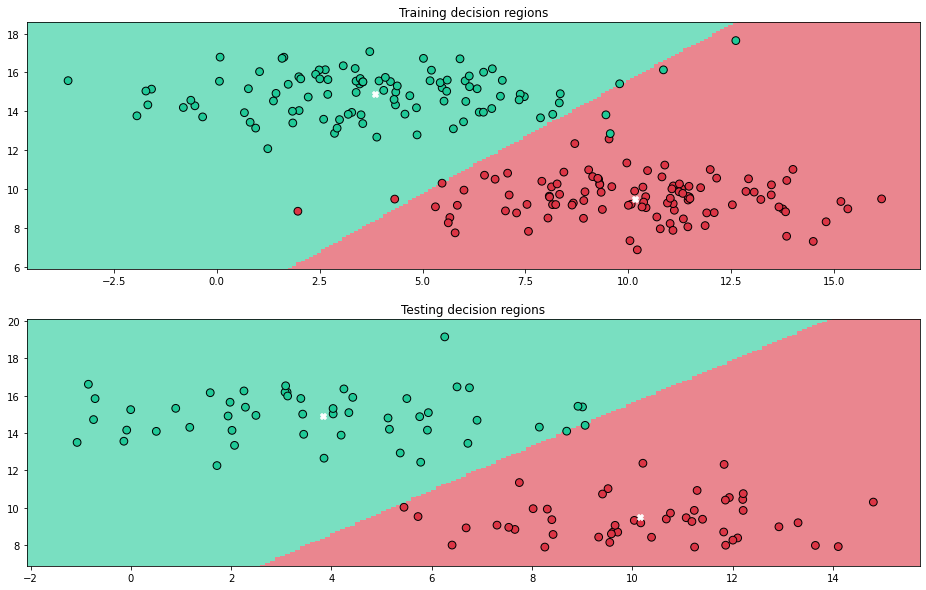

In [14]:
fig = plt.figure(figsize=(16,10))
# Training
ax = fig.add_subplot(2, 1, 1)
my.plot_decision_regions(train.inputs, train.target, rbf, resolution=0.1, title="Training decision regions", ax=ax) 
a_ = mu0[:, :-1]
ax.scatter(a_[:, 0], a_[:, 1], color='white', marker='X')
b_ = mu1[:, :-1]
ax.scatter(b_[:, 0], b_[:, 1], color='white', marker='X')

# Testing
ax = fig.add_subplot(2, 1, 2)
my.plot_decision_regions(test.inputs, test.target, rbf, resolution=0.1, title="Testing decision regions",  ax=ax )
a_ = mu0[:, :-1]
ax.scatter(a_[:, 0], a_[:, 1], color='white', marker='X')

b_ = mu1[:, :-1]
ax.scatter(b_[:, 0], b_[:, 1], color='white', marker='X')

## Using RBF networks for multiclass classification
Here we are going to use the iris dataset and since it is a multiclass dataset, we will use softmax function. 

In [19]:
data = sns.load_dataset("iris")

data = data.iloc[:, [0,2, 4]]
data.iloc[:, -1] = data.iloc[:, -1].apply(lambda x: 0 if x == 'setosa' else (1 if x == 'versicolor' else 2))

ds = my.DataSet(data, y=True)

datasets = ds.train_test_split(test_portion=.25, shuffle=True)

dfs = []
inputs = []
targets = []
for i in range(len(datasets)):
    df = datasets[i].examples
    t_df = pd.DataFrame({
        'y1': df.iloc[:, -1].apply(lambda x: 1 if x == 0 else 0),
        'y2': df.iloc[:, -1].apply(lambda x: 1 if x == 1 else 0),
        'y3': df.iloc[:, -1].apply(lambda x: 1 if x == 2 else 0)
    })

    full_df = pd.concat([df.iloc[:, :-1], t_df], axis=1)
    inputs.append(full_df.values[:,:2])
    targets.append(full_df.values[:,2:])
    dfs.append(full_df)
    
rbf = RBFNet(my.DataSet(dfs[0]), nOutput=3, outType='softmax')
rbf.fit()

cm = my.confusion_matrix(datasets[0].target, rbf.predict(inputs[0]))
accuracy = np.trace(cm) / np.sum(cm)
print(cm)
print('Training accuracy: ', accuracy)

cm = my.confusion_matrix(datasets[1].target, rbf.predict(inputs[1]))
accuracy = np.trace(cm) / np.sum(cm)
print(cm)
print('Testing accuracy: ', accuracy)

[[35  0  0]
 [ 0 39  0]
 [ 0  1 38]]
Training accuracy:  0.9911504424778761
[[15  0  0]
 [ 0 10  1]
 [ 0  1 10]]
Testing accuracy:  0.9459459459459459


Here are the decision regions' plots for both the training and testing datasets.

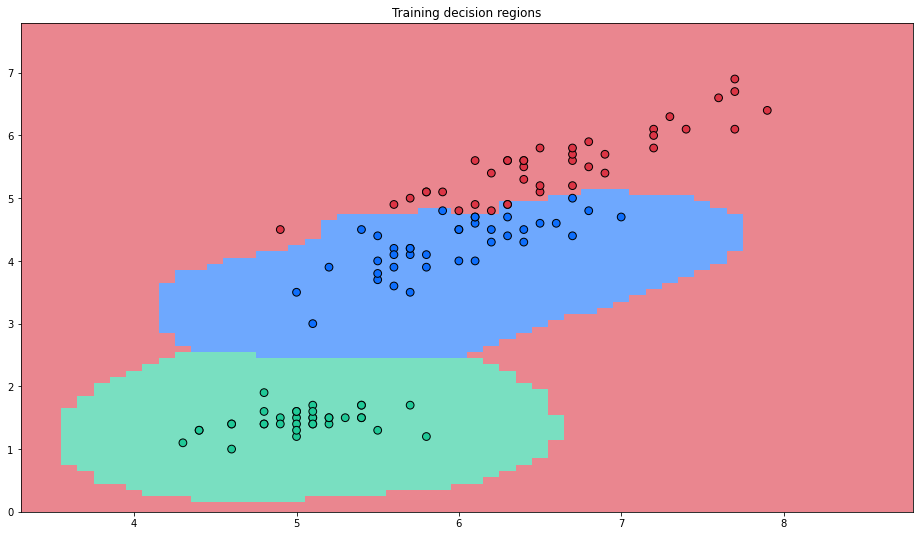

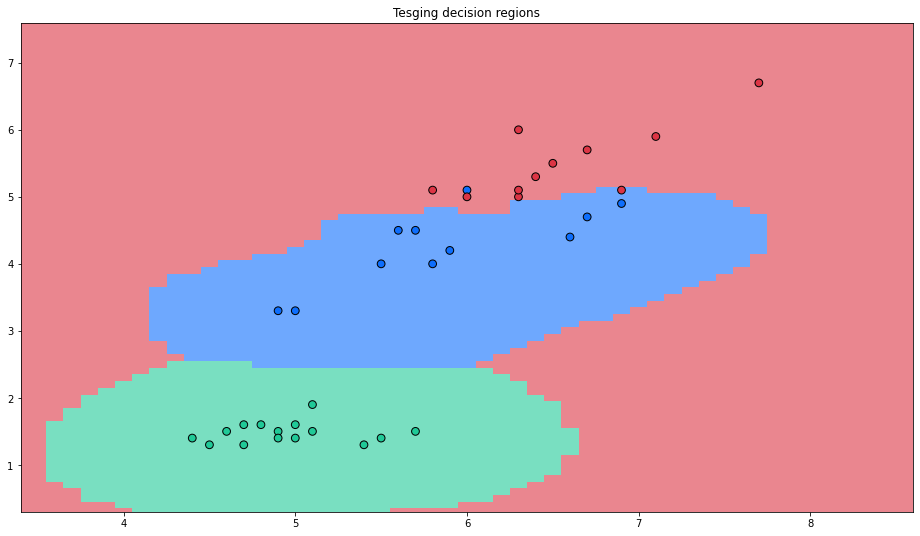

In [20]:
my.plot_decision_regions(inputs[0], datasets[0].target, rbf, resolution=0.1, title="Training decision regions")
my.plot_decision_regions(inputs[1], datasets[1].target, rbf, resolution=0.1, title="Tesging decision regions")

## Function approximation
Like MLPs, RBF networks are universal approximators. Here is an example demonstrating that.

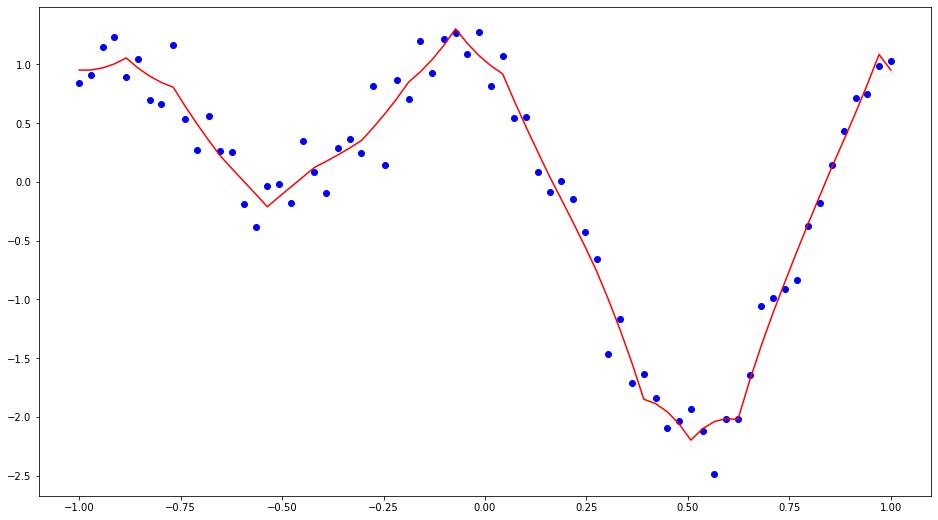

In [21]:
x = np.linspace(0,1,70)
y = np.sin(2*np.pi*x) + np.cos(4*np.pi*x) + np.random.randn(70)*0.2
x = (x-0.5)*2

df = pd.DataFrame({'x': x, 'y': y})
ds = my.DataSet(df, y=True)

fig = plt.figure(figsize=(16,9))

rbf = RBFNet(ds, mu=ds.inputs[::4,:], outType='linear')
rbf.fit()

ax = fig.add_subplot(1, 1, 1)

ax.scatter(x, y, color='b', marker='o')
ax.plot(x, rbf.predict(ds.inputs), 'r-')

## CHALLENGE
Here is the example dataset from the logistic regression notebook:

In [100]:
n = 150
data = np.array([[3, 14],[10, 9]])
d0 = np.concatenate((data[0,0] + np.random.normal(loc=1, scale=2.8, size=(n, 1)), 
                data[0, 1] + np.random.normal(loc=1, scale=1.2, size=(n, 1)), np.zeros(n).reshape(n, 1)), axis= 1)

d1 = np.concatenate((data[1,0] + np.random.normal(loc=.5, scale=2.5, size=(n, 1)), 
                data[1, 1] + np.random.normal(loc=.5, scale=1, size=(n, 1)), np.ones(n).reshape(n, 1)), axis= 1)


d = np.concatenate((d0, d1), axis=0)
data = my.DataSet(pd.DataFrame(d, columns=['x1', 'x2', 'y']), y=True)

Modify the `RBFNet` class above so as to support the logistic (sigmoid) function as an output activation function for binary classification. Test your change on the above dataset by displaying the training and testing confusion matrices, accuracies, and decision regions. Play with different thresholds such as 0.3, 0.5 and 0.7.

In [101]:
# TODO
class RBFNetChallenge:
    def __init__(self, dataset, sigma=0, mu=None, nOutput=1, outType='linear'):
        self.inputs = dataset.examples.values[:, :-nOutput]
        self.target = dataset.examples.values[:, -nOutput:]
        self.mu = self.inputs if mu is None else mu 
        self.nOutput = nOutput
        self.outType = outType
        max_range = (self.inputs.max(axis=0) - self.inputs.min(axis=0)).max()
        self.sigma =  max_range / np.sqrt(2 * len(self.mu)) if sigma == 0 else sigma
        self.r = 2 * self.sigma**2
        self.bias = len(self.mu) == len(self.inputs)
        
    def rbf(self, xn, sigma):
        d = self.inputs - np.ones([1, len(xn)]) * xn
        return nb.exp(np.sum(d**2,axis=1)/(self.r))
    
    def fit(self):
        G = np.array([np.exp(-np.linalg.norm(self.inputs - i,axis=1) / self.r) for i in self.mu]).T
        if self.bias:
            G = np.concatenate([np.ones([len(self.inputs), 1]), G], axis=1)
            
        y = self.target
        self.w = np.dot(np.linalg.pinv(G), y)

    def predict(self, unseen, threshold=.5):
        if unseen.ndim == 1:
            x = np.exp(-np.linalg.norm(self.mu - unseen,axis=1) / self.r)
            if self.bias:
                x = np.insert(x, 0, 1)
                
            y = np.dot(x, self.w)
            if self.outType == 'softmax':
                return np.argmax(np.exp(y) / np.sum(np.exp(y)))
            
            elif self.outType == 'perceptron':
                return np.sign(y)
            
            elif self.outType == 'sigmoid':
                if threshold != None and 0.0 < threshold < 1.0:
                    return 1 if 1 / (1 + np.exp(-y)) >= threshold else 0
                else:
                    return 1 / (1 + np.exp(-y))
            else:
                return y
        else:
            return np.array([self.predict(ex) for ex in unseen])

Threshold = .3

In [102]:
train, test = data.train_test_split(test_portion=0.33, shuffle=True)

rbf = RBFNetChallenge(train, mu=train.inputs[::1,:], outType='sigmoid')
rbf.fit()

cm = my.confusion_matrix(train.target, rbf.predict(train.inputs, threshold = .3))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Training accuracy: ', accuracy)

cm = my.confusion_matrix(test.target, rbf.predict(test.inputs, threshold = .3))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Testing accuracy: ', accuracy)

[[  1 101]
 [  0  99]]
Training accuracy:  0.4975124378109453
[[10 38]
 [ 0 51]]
Testing accuracy:  0.6161616161616161


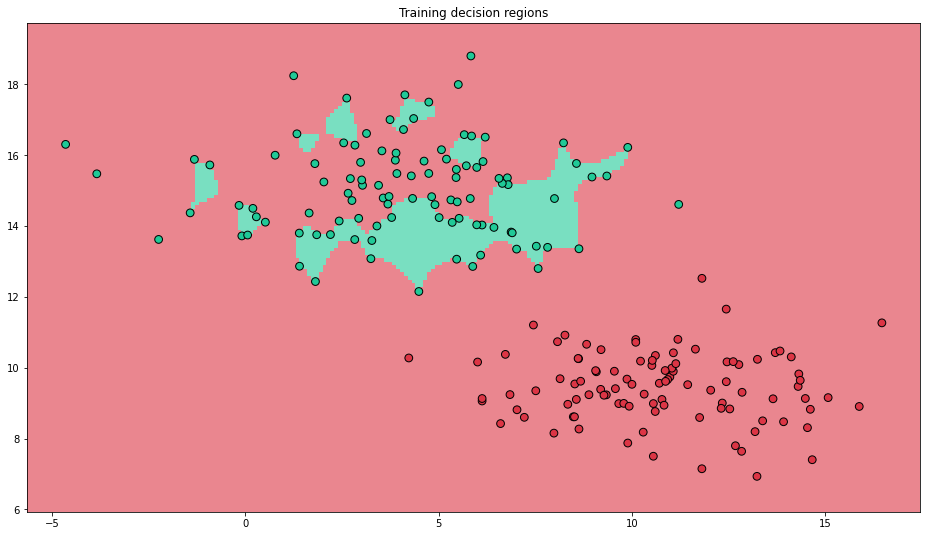

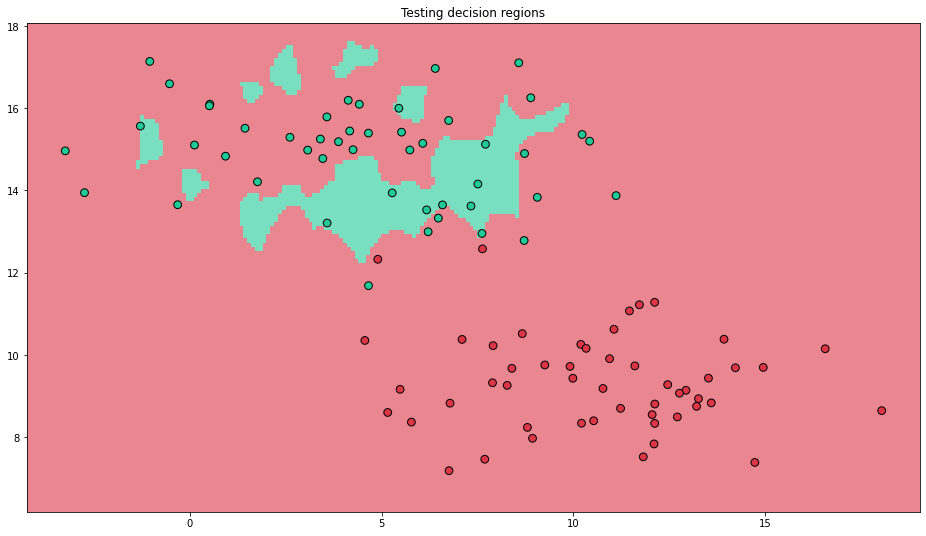

In [103]:
my.plot_decision_regions(train.inputs, train.target, rbf, resolution=0.1, title="Training decision regions")
my.plot_decision_regions(test.inputs, test.target, rbf, resolution=0.1, title="Testing decision regions")

Threshold = .5

In [104]:
train, test = data.train_test_split(test_portion=0.33, shuffle=True)

rbf = RBFNetChallenge(train, mu=train.inputs[::1,:], outType='sigmoid')
rbf.fit()

cm = my.confusion_matrix(train.target, rbf.predict(train.inputs))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Training accuracy: ', accuracy)

cm = my.confusion_matrix(test.target, rbf.predict(test.inputs))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Testing accuracy: ', accuracy)

[[  3  94]
 [  0 104]]
Training accuracy:  0.5323383084577115
[[10 43]
 [ 0 46]]
Testing accuracy:  0.5656565656565656


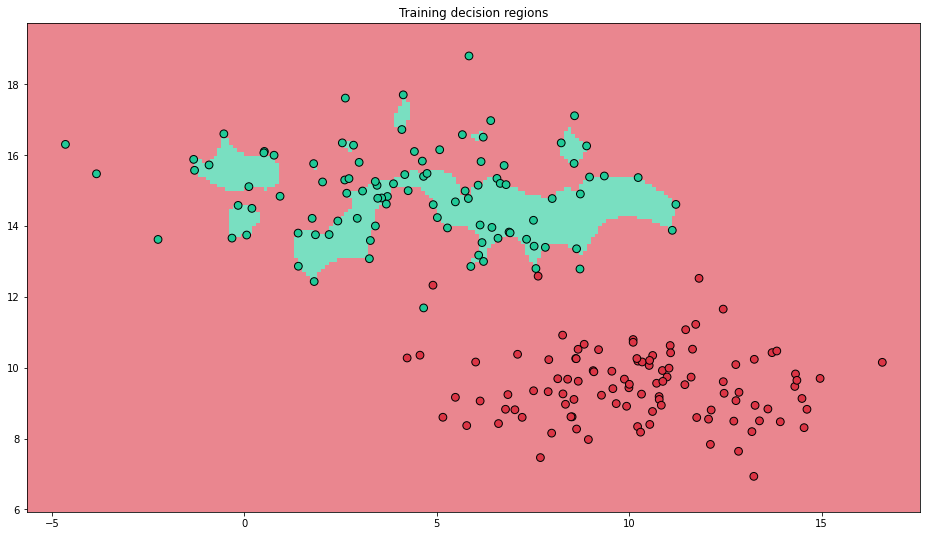

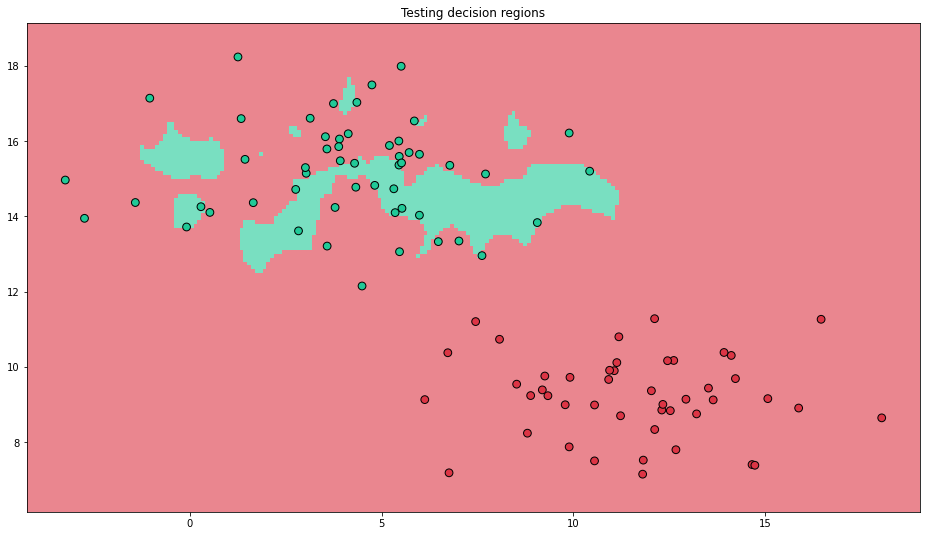

In [105]:
my.plot_decision_regions(train.inputs, train.target, rbf, resolution=0.1, title="Training decision regions")
my.plot_decision_regions(test.inputs, test.target, rbf, resolution=0.1, title="Testing decision regions")

Threshold = .7

In [106]:
train, test = data.train_test_split(test_portion=0.33, shuffle=True)

rbf = RBFNetChallenge(train, mu=train.inputs[::1,:], outType='sigmoid')
rbf.fit()

cm = my.confusion_matrix(train.target, rbf.predict(train.inputs, threshold = .7))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Training accuracy: ', accuracy)

cm = my.confusion_matrix(test.target, rbf.predict(test.inputs, threshold = .7))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Testing accuracy: ', accuracy)

[[ 77  24]
 [  0 100]]
Training accuracy:  0.8805970149253731
[[15 34]
 [ 0 50]]
Testing accuracy:  0.6565656565656566


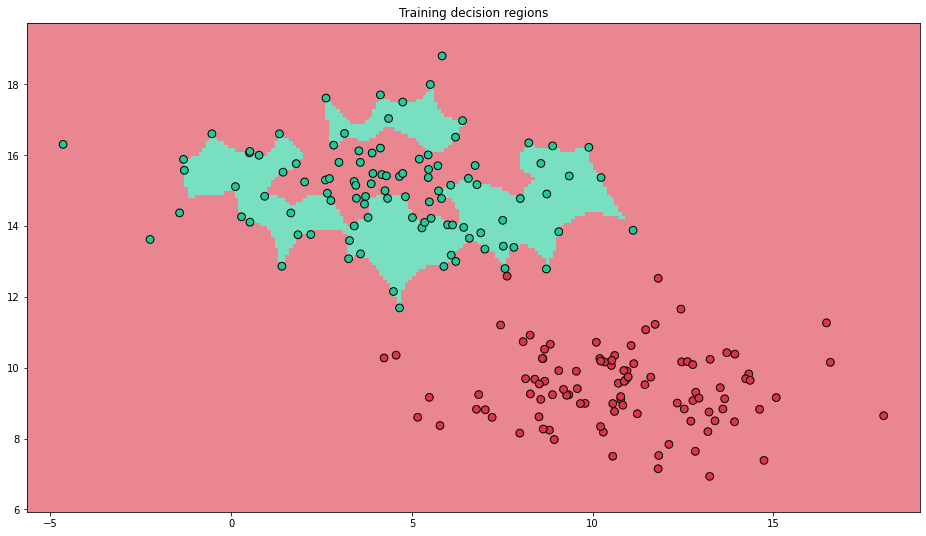

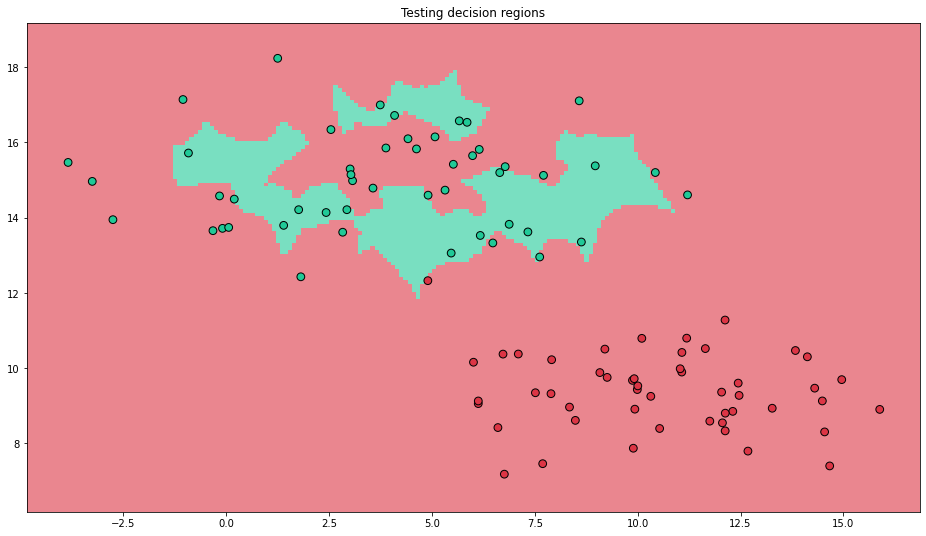

In [107]:
my.plot_decision_regions(train.inputs, train.target, rbf, resolution=0.1, title="Training decision regions")
my.plot_decision_regions(test.inputs, test.target, rbf, resolution=0.1, title="Testing decision regions")